In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re
from skdim.id import ESS

# ---------------------------------------------
# 1. Accuracy / Contribution 데이터 불러오기
# ---------------------------------------------
dataset = 'openai1m'
k_size = '50'
dim = 1536
subspace_num = 8
file_path = f'/home/sslab/yeojin/SuCo/result/{dataset}/{dataset}_{subspace_num}_0.05_0.005_K{k_size}_8.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()

# Recall 추출
recall_dict = {}
recall_pattern = re.compile(r"When k = (\d+), \(recall, ratio\) = \(([\d.]+),")
for line in lines:
    match = recall_pattern.search(line)
    if match:
        k = int(match.group(1))
        recall = float(match.group(2)) * 100
        recall_dict[k] = recall

# 데이터 시작점 찾기
data_start_index = -1
for i, line in enumerate(lines):
    if line.strip() == 'k,subspace,accuracy,contribution':
        data_start_index = i + 1
        break

if data_start_index == -1:
    raise ValueError("헤더를 찾을 수 없습니다.")

# 데이터프레임 생성
data_str = "".join(lines[data_start_index:])
df = pd.read_csv(io.StringIO(data_str), header=None, names=['k', 'subspace', 'accuracy', 'contribution'])
# "k,subspace,accuracy,contribution" 이후부터 읽되, 'Subspace' 라인이 나오기 전까지만 유지
end_index = len(lines)
for i in range(data_start_index, len(lines)):
    if lines[i].startswith('Subspace'):
        end_index = i
        break

data_str = "".join(lines[data_start_index:end_index])
df = pd.read_csv(io.StringIO(data_str), header=None, names=['k', 'subspace', 'accuracy', 'contribution'])

df['accuracy_percent'] = df['accuracy'].astype(float)
df['contribution_percent'] = df['contribution'].astype(float)

k_values = sorted(df['k'].unique())

In [11]:
# ---------------------------------------------
# 2. fbin 파일 불러오기 함수 정의
# ---------------------------------------------
def read_fbin(filename, dim, max_vectors=None):
    data = np.fromfile(filename, dtype=np.float32)

    # 앞 2개 float32는 헤더 (dim, num_vectors)
    header = data[:2]
    actual_data = data[2:]

    assert actual_data.size % dim == 0, "헤더 제외 후 데이터 크기가 dim으로 나누어떨어지지 않음"
    data = actual_data.reshape(-1, dim)

    if max_vectors:
        data = data[:max_vectors]
    return data

# ---------------------------------------------
# 3. Subspace별 Volume_mean 계산
# ---------------------------------------------
fbin_path = f'../dataset/{dataset}/{dataset}_base.fbin'
data = read_fbin(fbin_path, dim, max_vectors=10000)

split_size = dim // subspace_num
subspaces = []

for i in range(subspace_num):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < subspace_num - 1 else dim
    subspaces.append(list(range(start_idx, end_idx)))

sub_ess = ESS(ver='a', d=1)
summary = []

for i, feat_idx in enumerate(subspaces):
    X_sub = data[:, feat_idx]
    sub_ess.fit(X_sub, n_neighbors=20, smooth=False, comb='mean', n_jobs=-1)
    summary.append({
        "Subspace": i,
        "Volume_mean": np.mean(sub_ess._volumes_),
    })

volume_df = pd.DataFrame(summary)


In [13]:
for k in k_values:
    k_df = df[df['k'] == k]
    x = k_df['subspace']
    indices = range(len(x))
    acc = k_df['accuracy_percent']

    volume_k = volume_df[volume_df['Subspace'].isin(x)]
    volumes = volume_k.set_index("Subspace").loc[x]["Volume_mean"].values

    fig, ax1 = plt.subplots(figsize=(12, 4))
    bar_width = 0.4

    # 오른쪽 Y축: Volume_mean
    ax2 = ax1.twinx()
    ax2.bar([i + bar_width / 2 for i in indices], volumes, width=bar_width, color='orange', label='Volume Mean', zorder = 2)
    ax2.set_ylabel('Volume Mean', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(0, max(volumes) * 1.3)

    # 왼쪽 Y축: Accuracy
    ax1.bar([i - bar_width / 2 for i in indices], acc, width=bar_width, color='skyblue', label='Accuracy (%)', zorder=2)
    ax1.set_ylabel('Accuracy (%)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_ylim(0, 100)
    ax1.set_xlabel('Subspace')
    ax1.set_xticks(indices)
    ax1.set_xticklabels(k_df['subspace'])

    # Recall 점선
    if k in recall_dict:
        recall = recall_dict[k]
        ax1.axhline(y=recall, color='red', linestyle='--', linewidth=1.5, label=f'Recall = {recall:.1f}%')
        ax1.text(len(x) - 2.6, recall - 4.5, f'Recall: {recall:.1f}%', color='red', fontsize=10)

    # for i, v in enumerate(acc):
    #     ax2.text(i - bar_width / 2, v + 1, f'{v:.1f}%', color='blue', ha='center', fontsize=9,
    #             transform=ax1.transData, zorder=10)
        
    # # Volume 수치 표시
    # for i, v in enumerate(volumes):
    #     ax2.text(i + bar_width / 2, v + max(volumes) * 0.03, f'{v:.5f}', color='darkorange', ha='center', fontsize=9, zorder=5)


    plt.title(f'[{dataset}] Accuracy & Volume by Subspace (K={k})')
    fig.tight_layout()

    # 범례
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(0.12, 0.9), fontsize=8)

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()

KeyError: "None of [Index([nan], dtype='float64', name='Subspace')] are in the [index]"

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re
from skdim.id import ESS

# ---------------------------------------------
# 1. Accuracy / Contribution 데이터 불러오기
# ---------------------------------------------
dataset = 'openai1m'
k_size = '50'
dim = 1536
subspace_num = 8
file_path = f'/home/sslab/yeojin/SuCo/result/{dataset}/{dataset}_8_0.05_0.005_K{k_size}_8.txt'

with open(file_path, 'r') as f:
    lines = f.readlines()

# Recall 추출
recall_dict = {}
recall_pattern = re.compile(r"When k = (\d+), \(recall, ratio\) = \(([\d.]+),")
for line in lines:
    match = recall_pattern.search(line)
    if match:
        k = int(match.group(1))
        recall = float(match.group(2)) * 100
        recall_dict[k] = recall

# 데이터 시작점 찾기
# "k,subspace,accuracy,contribution" 이후부터 시작
data_start_index = -1
for i, line in enumerate(lines):
    if line.strip() == 'k,subspace,accuracy,contribution':
        data_start_index = i + 1
        break

if data_start_index == -1:
    raise ValueError("헤더 'k,subspace,accuracy,contribution'를 찾을 수 없습니다.")

# 'Subspace' 라인이 나오기 전까지 끝 지점 탐색
end_index = len(lines)
for i in range(data_start_index, len(lines)):
    if lines[i].strip().startswith('Subspace'):
        end_index = i
        break

# 필요한 줄만 추출
data_str = "".join(lines[data_start_index:end_index])

# 데이터프레임 생성
df = pd.read_csv(io.StringIO(data_str), header=None, names=['k', 'subspace', 'accuracy', 'contribution'])
df['accuracy_percent'] = df['accuracy'].astype(float)
df['contribution_percent'] = df['contribution'].astype(float)

k_values = sorted(df['k'].unique())

# ---------------------------------------------
# 2. fbin 파일 불러오기 함수 정의
# ---------------------------------------------
def read_fbin(filename, dim, max_vectors=None):
    data = np.fromfile(filename, dtype=np.float32)

    # 앞 2개 float32는 헤더 (dim, num_vectors)
    header = data[:2]
    actual_data = data[2:]

    assert actual_data.size % dim == 0, "헤더 제외 후 데이터 크기가 dim으로 나누어떨어지지 않음"
    data = actual_data.reshape(-1, dim)

    if max_vectors:
        data = data[:max_vectors]
    return data


# ---------------------------------------------
# 3. Subspace별 Volume_mean 계산
# ---------------------------------------------
fbin_path = f'../dataset/{dataset}/{dataset}_base.fbin'
data = read_fbin(fbin_path, dim, max_vectors=10000)

split_size = dim // subspace_num
subspaces = []

for i in range(subspace_num):
    start_idx = i * split_size
    end_idx = (i + 1) * split_size if i < subspace_num - 1 else dim
    subspaces.append(list(range(start_idx, end_idx)))

sub_ess = ESS(ver='a', d=1)
summary = []

for i, feat_idx in enumerate(subspaces):
    X_sub = data[:, feat_idx]
    sub_ess.fit(X_sub, n_neighbors=20, smooth=False, comb='mean', n_jobs=-1)
    summary.append({
        "Subspace": i,
        "Volume_mean": np.mean(sub_ess._volumes_),
    })

volume_df = pd.DataFrame(summary)

# ---------------------------------------------
# 4. Plotting: Accuracy(%) + Volume_mean
# ---------------------------------------------
for k in k_values:
    k_df = df[df['k'] == k]
    x = k_df['subspace']
    indices = range(len(x))
    acc = k_df['accuracy_percent']

    volume_k = volume_df[volume_df['Subspace'].isin(x)]
    volumes = volume_k.set_index("Subspace").loc[x]["Volume_mean"].values

    fig, ax1 = plt.subplots(figsize=(6, 4))
    bar_width = 0.4

    # 왼쪽 Y축: Accuracy
    ax1.bar([i - bar_width / 2 for i in indices], acc, width=bar_width, color='skyblue', label='Accuracy (%)')
    ax1.set_ylabel('Accuracy (%)', color='skyblue')
    ax1.tick_params(axis='y', labelcolor='skyblue')
    ax1.set_ylim(0, 100)
    ax1.set_xlabel('Subspace')
    ax1.set_xticks(indices)
    ax1.set_xticklabels(k_df['subspace'])

    for i, v in enumerate(acc):
        ax1.text(i - bar_width / 2, v + 1, f'{v:.1f}%', color='blue', ha='center', fontsize=9)

    # Recall 점선
    if k in recall_dict:
        recall = recall_dict[k]
        ax1.axhline(y=recall, color='red', linestyle='--', linewidth=1.5, label=f'Recall = {recall:.1f}%')
        ax1.text(len(x) - 2.6, recall + 1, f'Recall: {recall:.1f}%', color='red', fontsize=10)

    # 오른쪽 Y축: Volume_mean
    ax2 = ax1.twinx()
    ax2.bar([i + bar_width / 2 for i in indices], volumes, width=bar_width, color='orange', label='Volume Mean')
    ax2.set_ylabel('Volume Mean', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(0, max(volumes) * 1.3)

    plt.title(f'Accuracy & Volume by Subspace (K={k})')
    fig.tight_layout()

    # 범례
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(0.12, 0.9), fontsize=8)

    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.show()



KeyError: "None of [Index([nan], dtype='float64', name='Subspace')] are in the [index]"

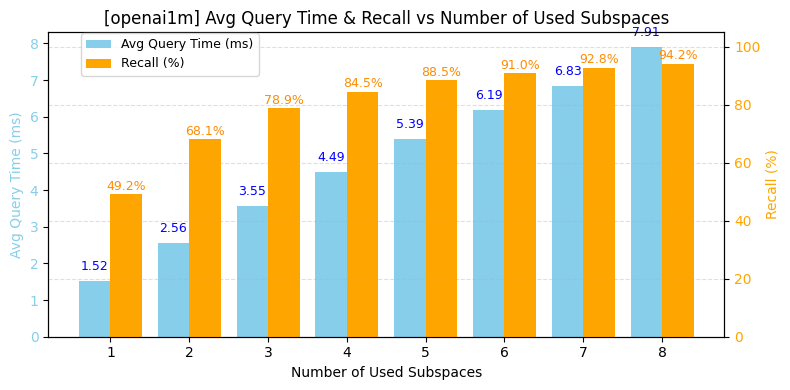

In [21]:
import os
import re
import matplotlib.pyplot as plt

# 디렉토리 및 파일 패턴
dir_path = '../result/openai1m/'
base_name = 'openai1m_8_0.05_0.005_K50_'
query_times = []
recalls = []
subspace_counts = []

# 파일 1~8까지 순회
for i in range(1, 9):
    file_path = os.path.join(dir_path, f'{base_name}{i}.txt')
    with open(file_path, 'r') as f:
        text = f.read()

    # average query time 파싱
    query_time_match = re.search(r'The average query time is ([\d.]+)ms', text)
    recall_match = re.search(r'When k = \d+, \(recall, ratio\) = \(([\d.]+),', text)

    if query_time_match and recall_match:
        avg_time = float(query_time_match.group(1))
        recall_percent = float(recall_match.group(1)) * 100

        query_times.append(avg_time)
        recalls.append(recall_percent)
        subspace_counts.append(i)
    else:
        print(f"[!] Parsing failed for {file_path}")

# -----------------------
# Plotting
# -----------------------
fig, ax1 = plt.subplots(figsize=(8, 4))
bar_width = 0.4
indices = range(len(subspace_counts))

# ax1: Query Time (왼쪽 Y축)
ax1.bar([i - bar_width / 2 for i in indices], query_times, width=bar_width,
        color='skyblue', label='Avg Query Time (ms)')
ax1.set_ylabel('Avg Query Time (ms)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xlabel('Number of Used Subspaces')
ax1.set_xticks(indices)
ax1.set_xticklabels(subspace_counts)

# ax2: Recall (오른쪽 Y축)
ax2 = ax1.twinx()
ax2.bar([i + bar_width / 2 for i in indices], recalls, width=bar_width,
        color='orange', label='Recall (%)')
ax2.set_ylabel('Recall (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 105)

# Label 표시
for i, (qt, rc) in enumerate(zip(query_times, recalls)):
    ax1.text(i - bar_width / 2, qt + 0.3, f'{qt:.2f}', ha='center', fontsize=9, color='blue')
    ax2.text(i + bar_width / 2, rc + 1.5, f'{rc:.1f}%', ha='center', fontsize=9, color='darkorange')

# 범례
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
fig.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(0.1, 0.92), fontsize=9)

plt.title('[openai1m] Avg Query Time & Recall vs Number of Used Subspaces')
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


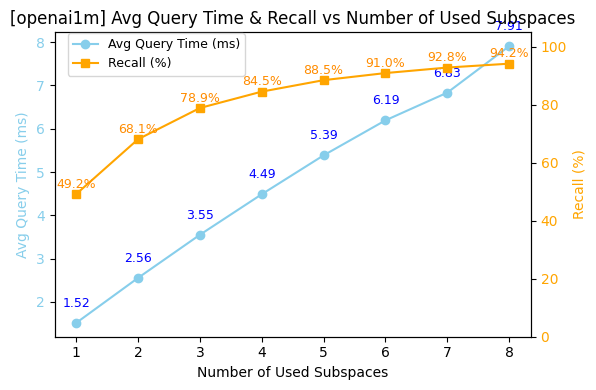

In [23]:

# --------------------
# 꺾은선 그래프 그리기
# --------------------
fig, ax1 = plt.subplots(figsize=(6, 4))

# 왼쪽 Y축: Query Time
ax1.plot(subspace_counts, query_times, marker='o', color='skyblue', label='Avg Query Time (ms)')
ax1.set_ylabel('Avg Query Time (ms)', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xlabel('Number of Used Subspaces')
ax1.set_xticks(subspace_counts)

# 오른쪽 Y축: Recall (%)
ax2 = ax1.twinx()
ax2.plot(subspace_counts, recalls, marker='s', color='orange', label='Recall (%)')
ax2.set_ylabel('Recall (%)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, 105)

# 값 라벨 추가
for x, qt, rc in zip(subspace_counts, query_times, recalls):
    ax1.text(x, qt + 0.3, f'{qt:.2f}', ha='center', va='bottom', fontsize=9, color='blue')
    ax2.text(x, rc + 1.2, f'{rc:.1f}%', ha='center', va='bottom', fontsize=9, color='darkorange')

# 범례 합치기
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(lines1 + lines2, labels1 + labels2, loc='upper left', bbox_to_anchor=(0.1, 0.92), fontsize=9)

plt.title('[openai1m] Avg Query Time & Recall vs Number of Used Subspaces')
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()